<a href="https://colab.research.google.com/github/LordLean/Acquired-Intelligence-Adaptive-Behaviour/blob/master/Week-by-Week/week1/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import nltk
from nltk.corpus import wordnet as wn, wordnet_ic as wn_ic, lin_thesaurus as lin
import operator

import pandas as pd
from scipy import stats
from IPython.display import display

from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
nltk.download("wordnet")
nltk.download("wordnet_ic")
nltk.download("lin_thesaurus")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.
[nltk_data] Downloading package lin_thesaurus to /root/nltk_data...
[nltk_data]   Unzipping corpora/lin_thesaurus.zip.


True

# Common WordNet Functions

In [3]:
synsets = wn.synsets("book", wn.NOUN)
synsetA = synsets[0]

In [4]:
# Definition
print(synsetA.definition(),"\n")
# Hyponym
print(synsetA.hyponyms(), "\n")
# Hypernym
print(synsetA.hypernyms(), "\n")
# Root
print(synsetA.root_hypernyms(), "\n")
# Co-hyponyms 
print(synsetA.hypernyms()[0].hyponyms())

a written work or composition that has been published (printed on pages bound together) 

[Synset('appointment_book.n.01'), Synset('authority.n.07'), Synset('bestiary.n.01'), Synset('booklet.n.01'), Synset('catalog.n.01'), Synset('catechism.n.02'), Synset('copybook.n.01'), Synset('curiosa.n.01'), Synset('formulary.n.01'), Synset('phrase_book.n.01'), Synset('playbook.n.02'), Synset('pop-up_book.n.01'), Synset('prayer_book.n.01'), Synset('reference_book.n.01'), Synset('review_copy.n.01'), Synset('songbook.n.01'), Synset('storybook.n.01'), Synset('textbook.n.01'), Synset('tome.n.01'), Synset('trade_book.n.01'), Synset('workbook.n.01'), Synset('yearbook.n.01')] 

[Synset('publication.n.01')] 

[Synset('entity.n.01')] 

[Synset('book.n.01'), Synset('collection.n.02'), Synset('impression.n.06'), Synset('magazine.n.01'), Synset('new_edition.n.01'), Synset('periodical.n.01'), Synset('read.n.01'), Synset('reference.n.08'), Synset('reissue.n.01'), Synset('republication.n.01'), Synset('tip_sheet.

In [5]:
def wordnet_synset_hierarchy(synset, reverse=False, lemma_names=False):
  """
  Returns ordered list of hypernyms paths from this synset to the root.
  """
  data = list(synset.hypernym_distances())
  if lemma_names:
    data = [(lemma.lemma_names()[0], rank) for lemma, rank in data]
  return sorted(data, key=lambda tup: tup[1], reverse=reverse)


def wordnet_synset_hierarchy_alt(synset):
  """
  Returns ordered list of hypernyms paths from this synset to the root.
  Alternative to above function.
  """
  lst = synset.hypernym_paths()[0]
  lst.reverse()
  return [depth for depth in enumerate(lst)]

In [6]:
wordnet_synset_hierarchy(synsetA)
wordnet_synset_hierarchy_alt(synsetA)

# dog = wn.synset('dog.n.01')
# hyp = lambda s:s.hypernyms()
# list(dog.closure(hyp))

[(0, Synset('book.n.01')),
 (1, Synset('publication.n.01')),
 (2, Synset('work.n.02')),
 (3, Synset('product.n.02')),
 (4, Synset('creation.n.02')),
 (5, Synset('artifact.n.01')),
 (6, Synset('whole.n.02')),
 (7, Synset('object.n.01')),
 (8, Synset('physical_entity.n.01')),
 (9, Synset('entity.n.01'))]

In [7]:
brown_ic=wn_ic.ic("ic-brown.dat")

In [8]:
synsetB = synsets[1]
print("res similarity: {}".format(synsetA.res_similarity(synsetB,brown_ic)))
print("lin similarity: {}".format(synsetA.lin_similarity(synsetB,brown_ic)))

res similarity: 5.454686565783099
lin similarity: 0.7098990245459575


In [9]:
def word_similarity(noun_x, noun_y, measure="path"):
  """
  Returns path similarity of two nouns.
  """
  synsets_x = wn.synsets(noun_x)
  synsets_y = wn.synsets(noun_y)
  val = 0
  for syn_x in synsets_x:
    for syn_y in synsets_y:
      try:
        if measure == "path":
          curr = syn_x.path_similarity(syn_y) 
        elif measure == "res":
          curr = syn_x.res_similarity(syn_y,brown_ic) 
        elif measure == "lin":
          curr = syn_x.lin_similarity(syn_y,brown_ic) 
      except:
        pass
      if curr:
        if curr > val:
          val = curr
  return round(val,4)

word_similarity("chicken","car")

0.0909

# Human Synonymy and Judgement

In [10]:
# Download mcdata.csv
!gdown --id 1d_-S7eje-yh2SKYTiJi78kk6k_LRfmHa

Downloading...
From: https://drive.google.com/uc?id=1d_-S7eje-yh2SKYTiJi78kk6k_LRfmHa
To: /content/mcdata.csv
100% 540/540 [00:00<00:00, 469kB/s]


In [44]:
### Load df
df = pd.read_csv("mcdata.csv")


### Setup df
# Drop column names as row.
df.loc[-1] = df.columns.to_list()
df.index = df.index + 1
df.sort_index(inplace=True)
# Rename columns.
df.rename(columns={"asylum": "Noun1", "madhouse": "Noun2", "3.61": "MC_sim_score"}, inplace=True)
# Convert dtype of MC_sim_score column.
df["MC_sim_score"] = pd.to_numeric(df["MC_sim_score"])
# Sort by MC_sim_score
df.sort_values(by=["MC_sim_score"], ascending=False, inplace=True)
# df.reset_index(drop=True, inplace=True)


### Create similarity scores for each noun pair using different semantic similarity measures.
df["path_sim_score"] = df.apply(lambda row: word_similarity(row.Noun1, row.Noun2), axis=1)
df["res_sim_score"] = df.apply(lambda row: word_similarity(row.Noun1, row.Noun2, "res"), axis=1)
df["lin_sim_score"] = df.apply(lambda row: word_similarity(row.Noun1, row.Noun2, "lin"), axis=1)


### Calculate Spearman's rank correlation coefficient and pvals for path_similarity + res/lin.
# path + res, path + lin
for col_name in ["res_sim_score", "lin_sim_score"]:
  rho, pval = stats.spearmanr(df["path_sim_score"], df[col_name])
  print("Correlation between path_sim_score and {} similiarity scores:".format(col_name))
  print("Spearmans: {}\np value: {}".format(rho, pval))
  print()


### Calculate Spearman's rank correlation coefficient and pvals for res + lin.
# res + lin
rho, pval = stats.spearmanr(df["res_sim_score"], df["lin_sim_score"])
print("Correlation between res and lin similiarity scores:")
print("Spearmans: {}\np value: {}".format(rho, pval))
print("\nHigh correlation coefficient suggests a strong correlation.\nLow p value suggests evidence points to an effect on this sample. ")


### Show correlation matrix for numerical columns of df.
df.corr(method="spearman")

Correlation between path_sim_score and res_sim_score similiarity scores:
Spearmans: 0.9155058830937143
p value: 1.3728011000739396e-12

Correlation between path_sim_score and lin_sim_score similiarity scores:
Spearmans: 0.9546218652028885
p value: 2.910621963360117e-16

Correlation between res and lin similiarity scores:
Spearmans: 0.962707165548334
p value: 1.9614906768607923e-17

High correlation coefficient suggests a strong correlation.
Low p value suggests evidence points to an effect on this sample. 


,MC_sim_score,path_sim_score,res_sim_score,lin_sim_score
MC_sim_score,1.000000,0.703810,0.735945,0.753510
path_sim_score,0.703810,1.000000,0.915506,0.954622
res_sim_score,0.735945,0.915506,1.000000,0.962707
lin_sim_score,0.753510,0.954622,0.962707,1.000000


# Distributional Similarity 

In [12]:
# Download GoogleNews-vectors-negative300.bin.gz
!gdown --id 1uPazG10_1ODUI_JmKYcNFxJeQDXwnsLO
!gunzip GoogleNews-vectors-negative300.bin.gz

Downloading...
From: https://drive.google.com/uc?id=1uPazG10_1ODUI_JmKYcNFxJeQDXwnsLO
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:23, 70.5MB/s]


In [49]:
filename="GoogleNews-vectors-negative300.bin"
model = KeyedVectors.load_word2vec_format(filename, binary=True)
df["word2vec_sim_score"] = df.apply(lambda row: model.similarity(row.Noun1, row.Noun2), axis=1)

In [50]:
display(df.corr())
conc = """
word2vec represents words as vectors and calculates cosine similarity between two such vectors.
High correlation score with the human synonymy judgements.
Relatively low scores with wordnet similarity.
"""
print(conc)

,MC_sim_score,path_sim_score,res_sim_score,lin_sim_score,word2vec_sim_score
MC_sim_score,1.000000,0.742355,0.812641,0.805583,0.804206
path_sim_score,0.742355,1.000000,0.887540,0.875707,0.647897
res_sim_score,0.812641,0.887540,1.000000,0.964375,0.612334
lin_sim_score,0.805583,0.875707,0.964375,1.000000,0.597420
word2vec_sim_score,0.804206,0.647897,0.612334,0.597420,1.000000



word2vec represents words as vectors and calculates cosine similarity between two such vectors.
High correlation score with the human synonymy judgements.
Relatively low scores with wordnet similarity.



In [42]:
# Print table to markdown.
# print(df.to_markdown())

# Extension: Significance Testing

path_sim_score correlation coefficient: 0.8616003518560421
res_sim_score correlation coefficient: 0.9014658540398356
lin_sim_score correlation coefficient: 0.897542786429843
word2vec_sim_score correlation coefficient: 0.8967753734632006


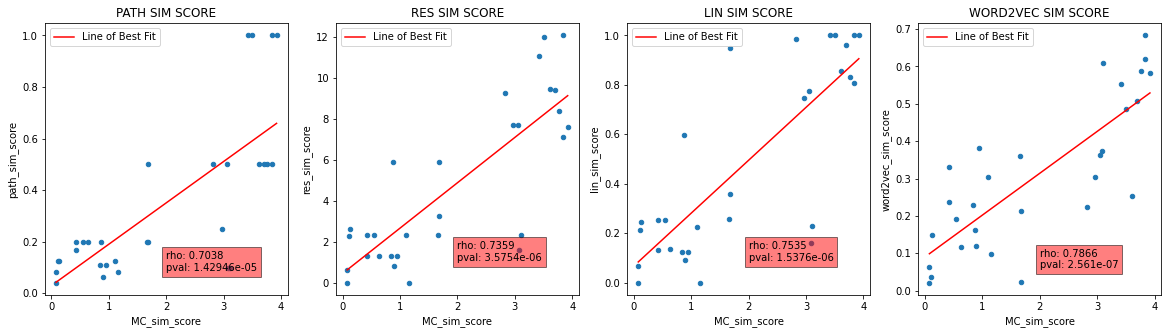

In [129]:
col_names = df.columns.to_list()[3:]

fig, axes = plt.subplots(nrows=1, ncols=len(col_names), figsize=(20, 5))
for i, column in enumerate(col_names):
  # Create title.
  title = column.replace("_"," ").upper()

  # Create plot.
  df.plot.scatter(x="MC_sim_score", y=column, ax=axes[i], title=title)

  # Get scipy lin regression:
  x = df["MC_sim_score"]
  y = df[column]
  res = stats.linregress(x, y)
  # Plot regression line.
  axes[i].plot(x, res.intercept + res.slope * x, "r", label="Line of Best Fit")
  axes[i].legend()

  # Get correlation coefficient and p value from spearmans.
  rho, pval = stats.spearmanr(x, y)
  text = "rho: {}\npval: {}".format(round(rho,4),round(pval,10))
  # Write rho and pval to figure.
  y = axes[i].get_ylim()[1] / 12
  axes[i].text(2,y,text,bbox=dict(facecolor='red', alpha=0.5))

  print("{} correlation coefficient: {}".format(column, math.sqrt(res.rvalue)))
  
fig.show()